In [1]:
import os
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import torch.cuda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import TimesformerModel, TimesformerConfig
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load csv and sample 15 random movies from each genre:

In [2]:

# Load your dataset
df = pd.read_csv("../movie_data_2000_with_trailers.csv")

# Clean and explode genres
df['genres'] = df['genres'].fillna('').apply(lambda g: [x.strip() for x in g.split(',') if x.strip()])
exploded = df.explode('genres')

# Filter down to top genres
top_genres = exploded['genres'].value_counts().head(10).index.tolist()
samples_per_genre = 15  # 10 genres x 15 = 150

balanced_samples = []

for genre in top_genres:
    genre_df = exploded[exploded['genres'] == genre]
    
    # Drop entries without valid revenue or trailer
    genre_df = genre_df.dropna(subset=['revenue', 'trailer'])
    genre_df = genre_df[genre_df['revenue'] > 0]
    
    if len(genre_df) < 3:
        continue  # skip genre if too small

    # Bin by revenue (low/mid/high)
    genre_df['revenue_bin'] = pd.qcut(genre_df['revenue'], q=3, labels=['low', 'mid', 'high'], duplicates='drop')
    
    # Sample evenly across bins
    per_bin = samples_per_genre // 3
    genre_sample = pd.concat([
        genre_df[genre_df['revenue_bin'] == bin_label].sample(
            n=min(per_bin, len(genre_df[genre_df['revenue_bin'] == bin_label])),
            random_state=42
        )
        for bin_label in ['low', 'mid', 'high']
    ])
    
    balanced_samples.append(genre_sample)

# Merge and deduplicate
sampled_df = pd.concat(balanced_samples).drop_duplicates(subset='id').reset_index(drop=True)
sampled_df

,id,genres,original_title,overview,backdrop_path,poster_path,budget,release_date,revenue,runtime,year,trailer,revenue_bin
0,628922,Drama,Asphalt City,A young paramedic is paired with a seasoned pa...,/yPiCixZDLeBXF8xO4xpw8SJlaKn.jpg,/qXcd7wY7MmRs36fQt83iSMJelvV.jpg,0,2024-03-28,488002,120,2024,m5buqYihMg8,low
1,557950,Drama,Mainstream,A young woman thinks she’s found a path to int...,/lpDI75ThFlgMvgCxetaIU0cJeLy.jpg,/6dvHSlWmEhOJDFD75ncHeBZ2n9t.jpg,5000000,2021-05-07,49638,95,2021,Rlpm36Vi-3U,low
2,87440,Drama,Struck by Lightning,"After being struck and killed by lightning, a ...",/7LM4nm9QSmIUWvIVYGiEXwqMfO8.jpg,/iceZkHBrLTgeXZF7Z3gANJgiNQM.jpg,0,2013-06-19,22930,90,2013,JAakou4Kdhw,low
3,8414,Drama,Interview,"After falling out with his editor, a fading po...",/u7joMKgr6olZ4A8nGgztYJR1YDG.jpg,/jObPGoyEcBFB8x5j3Htabavgcxx.jpg,0,2007-07-13,1441846,84,2007,vCHUibmnZi4,low
4,257440,Drama,Term Life,"If Nick Barrow can stay alive for 21 days, he'...",/8yM0mNM5begExtTdmsi5ZnK4Ipm.jpg,/9oAVYDh7RHW3wzQWbGsRB7RFE6J.jpg,16500000,2016-04-29,21256,93,2016,WgNWtyKHods,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,585,Family,"Monsters, Inc.",Lovable Sulley and his wisecracking sidekick M...,/sDTnMOJ3H5wI38OxObmCtK7wfd5.jpg,/qjlbN6aK1qgeg3SspFVovT2D1Me.jpg,115000000,2001-11-01,579700000,92,2001,GnuQH_ASzu8,high
145,73723,Family,The Lorax,A 12-year-old boy searches for the one thing t...,/71FjlP0qZPc1iymcHf8u5vXfH50.jpg,/tePFnZFw5JvjwjQjaKkqDPNMLPU.jpg,70000000,2012-03-01,349305397,86,2012,XbGnmKPSq9k,high
146,11887,Family,High School Musical 3: Senior Year,"As seniors in high school, Troy and Gabriella ...",/1czvi8gsu675rH2XjSxHyPBUv95.jpg,/aq2o1wT0crBOTxof36O6KTyjpgE.jpg,11000000,2008-10-11,252909177,112,2008,1S8RTKL5cW8,high
147,438695,Family,Sing 2,Buster and his new cast now have their sights ...,/ztiFxuG0gC6wQ8y7JZFYbCQyN4Y.jpg,/aWeKITRFbbwY8txG5uCj4rMCfSP.jpg,85000000,2021-12-01,408402685,109,2021,EPZu5MA2uqI,high


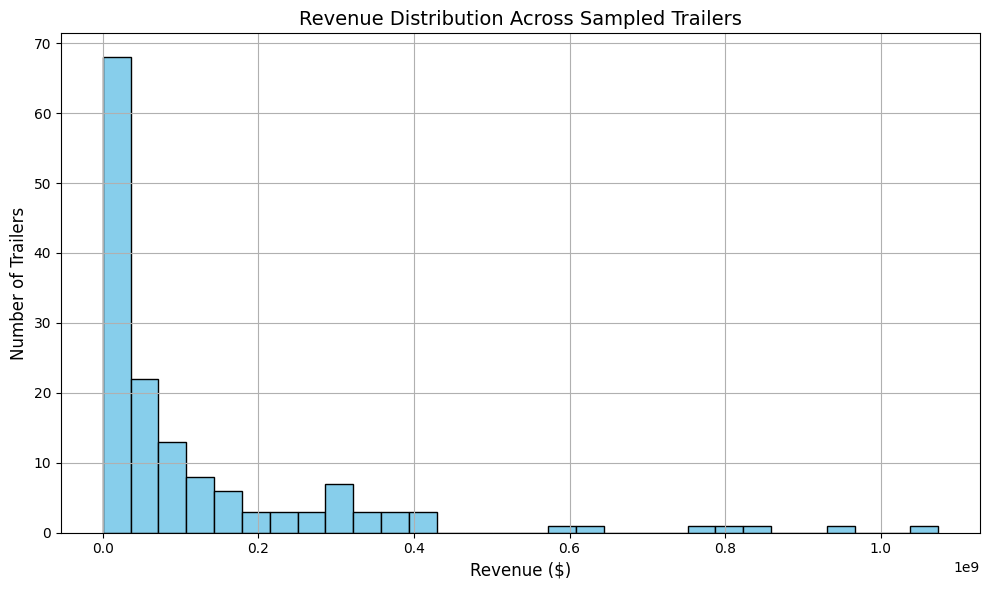

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(sampled_df['revenue'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Revenue ($)', fontsize=12)
plt.ylabel('Number of Trailers', fontsize=12)
plt.title('Revenue Distribution Across Sampled Trailers', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Extract keyframes from trailers - 1 per second

In [33]:
def get_video_stream_url(video_id):
    url = f"https://www.youtube.com/watch?v={video_id}"
    ydl_opts = {
        'quiet': True,
        'format': 'best[ext=mp4][height<=480]',
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=False)
        return info['url']

def extract_keyframes_from_stream(stream_url, output_dir, video_id):
    cap = cv2.VideoCapture(stream_url)
    if not cap.isOpened():
        print(f"Could not open stream for video {video_id}")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    frame_interval = int(fps)
    frame_idx = 0
    saved = 0
    os.makedirs(output_dir, exist_ok=True)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_interval == 0:
            frame_path = os.path.join(output_dir, f"{video_id}_frame{saved}.jpg")
            cv2.imwrite(frame_path, frame)
            saved += 1
        frame_idx += 1
    cap.release()

for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df)):
    video_id = row['trailer']
    try:
        stream_url = get_video_stream_url(video_id)
        extract_keyframes_from_stream(stream_url, os.path.join("frames", video_id), video_id)
    except Exception as e:
        print(f"Error processing {video_id}: {e}")

 11%|█▏        | 17/149 [01:28<08:05,  3.68s/it]

Error processing s4TAfaddV4w: ERROR: [youtube] s4TAfaddV4w: Video unavailable. The uploader has not made this video available in your country


 26%|██▌       | 39/149 [02:55<05:55,  3.23s/it]

Error processing aqa3YTtwvaU: ERROR: [youtube] aqa3YTtwvaU: Video unavailable. The uploader has not made this video available in your country


 34%|███▎      | 50/149 [03:44<07:14,  4.39s/it]

Error processing DWfPGIMDhNw: ERROR: [youtube] DWfPGIMDhNw: Video unavailable. The uploader has not made this video available in your country


 51%|█████     | 76/149 [06:18<07:34,  6.23s/it]

Error processing -Wjjo30JJck: ERROR: [youtube] -Wjjo30JJck: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


 58%|█████▊    | 87/149 [07:32<04:54,  4.75s/it]

Error processing npFBRp716Qw: ERROR: [youtube] npFBRp716Qw: Video unavailable


ERROR: [youtube] x3ErWNBX9Rc: Video unavailable. The uploader has not made this video available in your country
 59%|█████▉    | 88/149 [07:33<03:44,  3.68s/it]

Error processing x3ErWNBX9Rc: ERROR: [youtube] x3ErWNBX9Rc: Video unavailable. The uploader has not made this video available in your country


 62%|██████▏   | 92/149 [08:14<10:55, 11.50s/it]

Could not open stream for video wRbWvJqOc24


 62%|██████▏   | 93/149 [08:43<15:35, 16.71s/it]ERROR: [youtube:truncated_id] 80112802: Incomplete YouTube ID 80112802. URL https://www.youtube.com/watch?v=80112802 looks truncated.


Could not open stream for video fpp5m6c0-jc
Error processing 80112802: ERROR: [youtube:truncated_id] 80112802: Incomplete YouTube ID 80112802. URL https://www.youtube.com/watch?v=80112802 looks truncated.


 72%|███████▏  | 108/149 [10:46<09:01, 13.21s/it]

Could not open stream for video 42jSUAMKjww


 93%|█████████▎| 138/149 [13:27<02:06, 11.50s/it]

Could not open stream for video MoxCRcmCydg


ERROR: [youtube] rwXe5eKZr6M: This video has been removed for violating YouTube's Terms of Service
 93%|█████████▎| 139/149 [13:28<01:22,  8.27s/it]

Error processing rwXe5eKZr6M: ERROR: [youtube] rwXe5eKZr6M: This video has been removed for violating YouTube's Terms of Service


100%|██████████| 149/149 [14:16<00:00,  5.75s/it]

Error processing Jb0hEE9yAbU: ERROR: [youtube] Jb0hEE9yAbU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Preprocess data

In [18]:
def drop_missing_keyframes(sample_df, frames_dir):
    # Keep only rows where the keyframe directory exists
    valid_rows = sample_df["trailer"].apply(
        lambda tid: os.path.isdir(os.path.join(frames_dir, str(tid)))
    )
    return sample_df[valid_rows].reset_index(drop=True)

sampled_df = drop_missing_keyframes(sampled_df, "frames")
sampled_df["log_revenue"] = np.log1p(sampled_df["revenue"])
sampled_df

,id,genres,original_title,overview,backdrop_path,poster_path,budget,release_date,revenue,runtime,year,trailer,revenue_bin,log_revenue
0,628922,Drama,Asphalt City,A young paramedic is paired with a seasoned pa...,/yPiCixZDLeBXF8xO4xpw8SJlaKn.jpg,/qXcd7wY7MmRs36fQt83iSMJelvV.jpg,0,2024-03-28,488002,120,2024,m5buqYihMg8,low,13.098077
1,557950,Drama,Mainstream,A young woman thinks she’s found a path to int...,/lpDI75ThFlgMvgCxetaIU0cJeLy.jpg,/6dvHSlWmEhOJDFD75ncHeBZ2n9t.jpg,5000000,2021-05-07,49638,95,2021,Rlpm36Vi-3U,low,10.812532
2,87440,Drama,Struck by Lightning,"After being struck and killed by lightning, a ...",/7LM4nm9QSmIUWvIVYGiEXwqMfO8.jpg,/iceZkHBrLTgeXZF7Z3gANJgiNQM.jpg,0,2013-06-19,22930,90,2013,JAakou4Kdhw,low,10.040245
3,8414,Drama,Interview,"After falling out with his editor, a fading po...",/u7joMKgr6olZ4A8nGgztYJR1YDG.jpg,/jObPGoyEcBFB8x5j3Htabavgcxx.jpg,0,2007-07-13,1441846,84,2007,vCHUibmnZi4,low,14.181435
4,257440,Drama,Term Life,"If Nick Barrow can stay alive for 21 days, he'...",/8yM0mNM5begExtTdmsi5ZnK4Ipm.jpg,/9oAVYDh7RHW3wzQWbGsRB7RFE6J.jpg,16500000,2016-04-29,21256,93,2016,WgNWtyKHods,low,9.964442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,426543,Family,The Nutcracker and the Four Realms,When Clara’s mother leaves her a mysterious gi...,/l2ji4YiNSPBV69WjGBgU0gCvRqy.jpg,/9vPDY8e7YxLwgVum7YZIUJbr4qc.jpg,120000000,2018-10-26,173961069,99,2018,FacrK2lLbYU,mid,18.974342
135,585,Family,"Monsters, Inc.",Lovable Sulley and his wisecracking sidekick M...,/sDTnMOJ3H5wI38OxObmCtK7wfd5.jpg,/qjlbN6aK1qgeg3SspFVovT2D1Me.jpg,115000000,2001-11-01,579700000,92,2001,GnuQH_ASzu8,high,20.178021
136,73723,Family,The Lorax,A 12-year-old boy searches for the one thing t...,/71FjlP0qZPc1iymcHf8u5vXfH50.jpg,/tePFnZFw5JvjwjQjaKkqDPNMLPU.jpg,70000000,2012-03-01,349305397,86,2012,XbGnmKPSq9k,high,19.671457
137,11887,Family,High School Musical 3: Senior Year,"As seniors in high school, Troy and Gabriella ...",/1czvi8gsu675rH2XjSxHyPBUv95.jpg,/aq2o1wT0crBOTxof36O6KTyjpgE.jpg,11000000,2008-10-11,252909177,112,2008,1S8RTKL5cW8,high,19.348541


In [29]:
import re

def numerical_sort_key(filename):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(r'(\d+)', filename)]

class MovieKeyframeDataset(Dataset):
    def __init__(self, dataframe, frame_dir, image_processor, num_frames=8):
        self.dataframe = dataframe
        self.frame_dir = frame_dir
        self.image_processor = image_processor
        self.num_frames = num_frames

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        trailer_id = row['trailer']
        label = torch.tensor(row['log_revenue'], dtype=torch.float32)

        # Get all available frames
        frame_folder = os.path.join(self.frame_dir, trailer_id)
        frame_files = sorted([
            f for f in os.listdir(frame_folder) if f.endswith(".jpg")
        ], key=numerical_sort_key)

        selected_frames = frame_files[3:self.num_frames+3]

        frames = []
        for fname in selected_frames:
            img_path = os.path.join(frame_folder, fname)
            img = Image.open(img_path).convert("RGB")
            frames.append(np.array(img))  # Convert to numpy for feature_extractor

        # Preprocess using HuggingFace extractor (returns dict with 'pixel_values')
        pixel_values = self.image_processor(frames, return_tensors="pt")["pixel_values"][0]

        return {
            "pixel_values": pixel_values,  # [T, C, H, W]
            "labels": label                # scalar
        }

['m5buqYihMg8_frame0.jpg', 'm5buqYihMg8_frame1.jpg', 'm5buqYihMg8_frame2.jpg', 'm5buqYihMg8_frame3.jpg', 'm5buqYihMg8_frame4.jpg', 'm5buqYihMg8_frame5.jpg', 'm5buqYihMg8_frame6.jpg', 'm5buqYihMg8_frame7.jpg', 'm5buqYihMg8_frame8.jpg', 'm5buqYihMg8_frame9.jpg', 'm5buqYihMg8_frame10.jpg', 'm5buqYihMg8_frame11.jpg', 'm5buqYihMg8_frame12.jpg', 'm5buqYihMg8_frame13.jpg', 'm5buqYihMg8_frame14.jpg', 'm5buqYihMg8_frame15.jpg', 'm5buqYihMg8_frame16.jpg', 'm5buqYihMg8_frame17.jpg', 'm5buqYihMg8_frame18.jpg', 'm5buqYihMg8_frame19.jpg', 'm5buqYihMg8_frame20.jpg', 'm5buqYihMg8_frame21.jpg', 'm5buqYihMg8_frame22.jpg', 'm5buqYihMg8_frame23.jpg', 'm5buqYihMg8_frame24.jpg', 'm5buqYihMg8_frame25.jpg', 'm5buqYihMg8_frame26.jpg', 'm5buqYihMg8_frame27.jpg', 'm5buqYihMg8_frame28.jpg', 'm5buqYihMg8_frame29.jpg', 'm5buqYihMg8_frame30.jpg', 'm5buqYihMg8_frame31.jpg', 'm5buqYihMg8_frame32.jpg', 'm5buqYihMg8_frame33.jpg', 'm5buqYihMg8_frame34.jpg', 'm5buqYihMg8_frame35.jpg', 'm5buqYihMg8_frame36.jpg', 'm5buqYihM

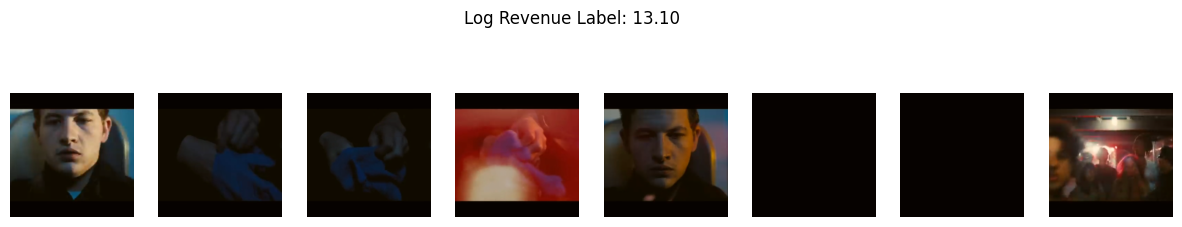

In [26]:
from transformers import AutoImageProcessor

# Load image processor
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

# Load dataset class
train_dataset = MovieKeyframeDataset(
    dataframe=sampled_df,
    frame_dir="frames",
    image_processor=processor,
    num_frames=8
)

sample = train_dataset[0]  # or: next(iter(train_loader)) if using DataLoader
pixel_values = sample["pixel_values"]  # [T, C, H, W]
label = sample["labels"]

# Prep frames for display
frames = pixel_values.permute(0, 2, 3, 1)  # [T, H, W, C]

# Unnormalize (ImageNet-style)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
frames = frames * std + mean
frames = torch.clamp(frames, 0, 1)

# Plot
n = frames.shape[0]
plt.figure(figsize=(15, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(frames[i].cpu().numpy())
    plt.axis('off')
plt.suptitle(f"Log Revenue Label: {label:.2f}")
plt.show()

TimeSformer Model

In [23]:
from transformers import TimesformerForVideoClassification

class TimeSformer(nn.Module):
    def __init__(self, model_name="facebook/timesformer-base-finetuned-k400"):
        super().__init__()
        self.backbone = TimesformerForVideoClassification.from_pretrained(model_name)

        hidden_size = self.backbone.config.hidden_size  # 768

        # Replace classification head with custom regression head
        self.backbone.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, pixel_values):  # input: [B, T, C, H, W]
        outputs = self.backbone(pixel_values)
        return outputs.logits.view(-1)  # output: [B]

Training Loop

In [24]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        y_true_train, y_pred_train = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            pixel_values = batch["pixel_values"].to(device)  # [B, T, C, H, W]
            labels = batch["labels"].to(device)              # [B]

            optimizer.zero_grad()
            outputs = model(pixel_values)                   # [B]
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * pixel_values.size(0)
            y_true_train.extend(labels.detach().cpu().numpy())
            y_pred_train.extend(outputs.detach().cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_r2 = r2_score(np.expm1(y_true_train), np.expm1(y_pred_train))

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * pixel_values.size(0)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(outputs.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_r2 = r2_score(np.expm1(y_true_val), np.expm1(y_pred_val))
        val_rmse = np.sqrt(mean_squared_error(np.expm1(y_true_val), np.expm1(y_pred_val)))
        val_mae = mean_absolute_error(np.expm1(y_true_val), np.expm1(y_pred_val))

        # --- Logging ---
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | R²: {train_r2:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | R²: {val_r2:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f}" )

In [30]:
model = TimeSformer() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_df, val_df = train_test_split(
    sampled_df,
    test_size=0.2,
    random_state=42,  # for reproducibility
    shuffle=True
)

train_dataset = MovieKeyframeDataset(train_df, "frames", processor, num_frames=8)
val_dataset = MovieKeyframeDataset(val_df, "frames", processor, num_frames=8)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = torch.nn.MSELoss()

train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10)

Epoch 1/10 [Validation]: 100%|██████████| 28/28 [01:01<00:00,  2.20s/it]



Epoch 1/10
Train Loss: 36.3474 | R²: -0.3537
Val   Loss: 11.4877 | R²: -0.3958 | RMSE: 311174327.6087 | MAE: 166992000.0000


Epoch 2/10 [Validation]: 100%|██████████| 28/28 [01:01<00:00,  2.19s/it]



Epoch 2/10
Train Loss: 8.7083 | R²: -0.3070
Val   Loss: 8.1472 | R²: -0.3637 | RMSE: 307581177.7919 | MAE: 162728048.0000


Epoch 3/10 [Validation]: 100%|██████████| 28/28 [01:01<00:00,  2.18s/it]



Epoch 3/10
Train Loss: 8.1926 | R²: -0.2647
Val   Loss: 9.3181 | R²: -0.3814 | RMSE: 309567771.4432 | MAE: 164936416.0000


Epoch 4/10 [Validation]: 100%|██████████| 28/28 [01:01<00:00,  2.18s/it]



Epoch 4/10
Train Loss: 8.5915 | R²: -0.2311
Val   Loss: 6.7162 | R²: -0.2791 | RMSE: 297891190.0615 | MAE: 153630192.0000


Epoch 5/10 [Validation]: 100%|██████████| 28/28 [01:02<00:00,  2.22s/it]



Epoch 5/10
Train Loss: 8.7976 | R²: -0.2785
Val   Loss: 11.1482 | R²: -0.3925 | RMSE: 310809632.6691 | MAE: 166724400.0000


Epoch 6/10 [Validation]: 100%|██████████| 28/28 [01:00<00:00,  2.15s/it]



Epoch 6/10
Train Loss: 8.0214 | R²: -0.2572
Val   Loss: 11.2745 | R²: -0.3947 | RMSE: 311060919.8373 | MAE: 166876336.0000


Epoch 7/10 [Validation]: 100%|██████████| 28/28 [01:01<00:00,  2.21s/it]



Epoch 7/10
Train Loss: 8.0563 | R²: -0.2909
Val   Loss: 7.3117 | R²: -0.3342 | RMSE: 304229377.9973 | MAE: 159316256.0000


Epoch 8/10 [Validation]: 100%|██████████| 28/28 [01:00<00:00,  2.17s/it]



Epoch 8/10
Train Loss: 8.4770 | R²: -0.2999
Val   Loss: 6.9187 | R²: -0.3065 | RMSE: 301061884.3620 | MAE: 156525600.0000


Epoch 9/10 [Validation]: 100%|██████████| 28/28 [01:14<00:00,  2.65s/it]



Epoch 9/10
Train Loss: 7.9351 | R²: -0.2715
Val   Loss: 7.8736 | R²: -0.3522 | RMSE: 306277221.5932 | MAE: 162062736.0000


Epoch 10/10 [Validation]: 100%|██████████| 28/28 [01:18<00:00,  2.80s/it]


Epoch 10/10
Train Loss: 8.1055 | R²: -0.3068
Val   Loss: 7.6335 | R²: -0.1035 | RMSE: 276688661.1883 | MAE: 143093440.0000


In [31]:
torch.save(model.state_dict(), 'best_trailer_model.pt')